# Sparse Fourier Transform

## Setup

In [1]:
%matplotlib inline
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import logging
logging.basicConfig(level=logging.INFO)
plt.rc("text", usetex=True)
plt.rc('font', family='serif', size=14)

In [2]:
def plot_compare(x_true, x_pred):
    fig, axs = plt.subplots(1, 3, figsize=(9, 3))
    axs[0].plot(x_pred["x"], label="pred")
    axs[0].plot(x_true["x"], label="true")
    axs[0].legend()
    axs[0].set(xlabel=r"$t$", ylabel=r"$x(t)$")
    axs[1].plot(x_pred["z"][0], label="pred")
    axs[1].plot(x_true["z"][0], label="true")
    axs[1].legend()
    axs[1].set(xlabel=r"$\omega$", ylabel=r"$\hat{x}(\omega)$", title="real")
    axs[2].plot(x_pred["z"][1], label="pred")
    axs[2].plot(x_true["z"][1], label="true")
    axs[2].legend()
    axs[2].set(xlabel=r"$\omega$", ylabel=r"$\hat{x}(\omega)$", title="imag")
    fig.tight_layout()
    
def plot_data(x, y):
    fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    ax.plot(x, label=r"$x(t)$")
    ax.plot(y, ".", label=r"$y(t)$")
    ax.legend()
    ax.set(xlabel=r"$t$")

In [3]:
from tramp.variables import SISOVariable as V, SILeafVariable as O, MILeafVariable, SIMOVariable 
from tramp.channels import DFTChannel, GaussianChannel 
from tramp.priors import GaussBernouilliPrior, GaussianPrior
from tramp.experiments import TeacherStudentScenario

## Sparse FFT denoising

We use sparsity of FFT $z = \hat{x}$ as prior information.

In [4]:
class SparseFFT_Teacher():
    def __init__(self, size, noise_var):
        self.t = np.linspace(-2*np.pi,2*np.pi, size, endpoint=False)
        self.channel = GaussianChannel(var=noise_var)
    def sample(self, seed=None, verbose=False):
        if seed:
            np.random.seed(seed)
        x = np.cos(self.t) + np.sin(2*self.t)
        z = DFTChannel(real=True).sample(x)
        nonzero = (np.abs(z) > 1e-11)
        y = self.channel.sample(x)
        if verbose:
            print(
                f"SparseFFT_Teacher: var(x) = {x.var(): .3f} "
                f"rho(z)={nonzero.mean(): .3f} var(z)={z[nonzero].var(): .3f}"
            )
        return {"x":x, "z":z, "y":y}

In [5]:
def get_sparse_fft_student(size, prior_var, fft_rho, fft_var, noise_var):
    x_shape = (size,)
    fft_shape = (2,) + x_shape
    student = (
        GaussianPrior(size=size, var=prior_var) @
        SIMOVariable(id="x", n_next=2) @ (
            GaussianChannel(var=noise_var) @ O("y") + (
                DFTChannel(real=True) +
                GaussBernouilliPrior(size=fft_shape, var=fft_var, rho=fft_rho)
            ) @
            MILeafVariable(id="z", n_prev=2)
        )
    ).to_model()
    return student

In [6]:
s = SparseFFT_Teacher(size=100, noise_var=0.1).sample(verbose=True)

SparseFFT_Teacher: var(x) =  1.000 rho(z)= 0.020 var(z)= 18.750


In [7]:
teacher = SparseFFT_Teacher(size=100, noise_var=0.1)
student = get_sparse_fft_student(size=100,  prior_var=1, fft_rho=0.02, fft_var=18, noise_var=0.1)
scenario = TeacherStudentScenario(teacher, student, x_ids=["x", "z"])

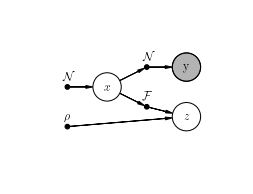

In [8]:
scenario.setup(seed=1)
scenario.student.plot()

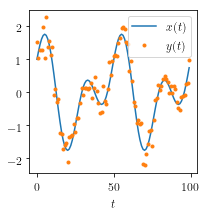

In [9]:
plot_data(scenario.x_true["x"], scenario.observations["y"])

In [10]:
from tramp.algos import EarlyStoppingEP
_ = scenario.run_ep(max_iter=200, damping=0, callback=EarlyStoppingEP(tol=1e-2))

INFO:tramp.algos.message_passing:init message dag with ConstantInit(a=0,b=0)
INFO:tramp.algos.message_passing:no damping
INFO:tramp.algos.callbacks:early stopping all tolerances (on r) are below tol=1.00e-02
INFO:tramp.algos.message_passing:terminated after n_iter=4 iterations


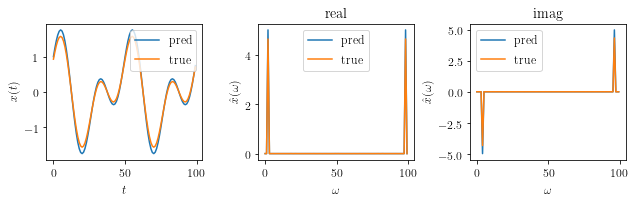

In [11]:
plot_compare(scenario.x_pred, scenario.x_true)